<a href="https://colab.research.google.com/github/phmouras/Projeto_Pos/blob/main/MS_spherical_collocation_shift_RKF45.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

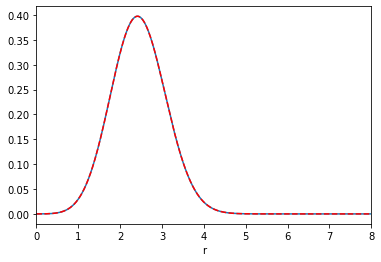

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

N = 30                                                  # Truncation ordem

L0 = 2                                               # Map parameter 

col = np.cos(np.arange(2*N + 4)*math.pi /(2*N + 3))      # collocation points (Verificado)

colr = col[1:N+2]

r = L0 * colr/(np.sqrt(1-colr**2))                       # physical domain (Verificado)             

out_r = open('r_30_L02.txt', 'a')
out_r.write(' ' +' '.join(str('%.18f'%n) for n in r)+'\n')
out_r.close()


# Base Matrix (Tchebyshev Polinomials): 

SB = np.zeros([N+2,N+1])
rSB = np.zeros([N+2,N+1])
rrSB = np.zeros([N+2,N+1])


for i in range(N+1+1):
  SB[i,] = np.sin((2*i+1)*np.arctan(L0/r))                                                  

for i in range(N+1+1):
  rSB[i,] = -np.cos((2*i+1)*np.arctan(L0/r))*(2*i+1)*L0/(r**2*(1+L0**2/r**2)) 

for i in range(N+1+1):
  rrSB[i,] = -np.sin((2*i+1)*np.arctan(L0/r))*(2*i+1)**2*L0**2/(r**4*(1+L0**2/r**2)**2)+2*np.cos((2*i+1)*np.arctan(L0/r))*(2*i+1)*L0/(r**3*(1+L0**2/r**2))-2*np.cos((2*i+1)*np.arctan(L0/r))*(2*i+1)*L0**3/(r**5*(1+L0**2/r**2)**2)                     


psi = SB[0:N+1,:]        # Base function
rpsi = rSB[0:N+1,:]
rrpsi = rrSB[0:N+1,:]

# Initial conditions of Phi                                     

r0 = 2

A0 = 0.081

sigma = 1

Phi_0 = A0*r**2*(np.exp(-(r-r0)**2/sigma**2)+np.exp(-(r+r0)**2/sigma**2))            # Phi initial data (Verificado)

inv_psi = np.linalg.inv(psi)
  
a0 = np.dot(Phi_0, inv_psi)  # coeficients a(0)  (Verificado)

out_a0 = open('a0_30_L02.txt', 'a')
out_a0.write(' ' +' '.join(str('%.18f'%n) for n in a0)+'\n')
out_a0.close()


Phi = np.dot(a0, psi)        # approximative solution in t = 0
rPhi= np.dot(a0, rpsi)

########################### Plot: Initial Conditions ph Phi

M = 3000       # plot truncation

rplot = np.linspace(0.000001,10,M)

colplot = rplot/np.sqrt(L0**2 + rplot**2)

SBplot = np.zeros([N+1,M])
rSBplot = np.zeros([N+1,M])
rrSBplot = np.zeros([N+1,M])

for i in range(N+1):
  SBplot[i,] = np.sin((2*i+1)*np.arctan(L0/rplot))

for i in range(N+1):
  rSBplot[i,] = -np.cos((2*i+1)*np.arctan(L0/rplot))*(2*i+1)*L0/(rplot**2*(1+L0**2/rplot**2)) 

for i in range(N+1):
  rrSBplot[i,] = -np.sin((2*i+1)*np.arctan(L0/rplot))*(2*i+1)**2*L0**2/(rplot**4*(1+L0**2/rplot**2)**2)+2*np.cos((2*i+1)*np.arctan(L0/rplot))*(2*i+1)*L0/(rplot**3*(1+L0**2/rplot**2))-2*np.cos((2*i+1)*np.arctan(L0/rplot))*(2*i+1)*L0**3/(rplot**5*(1+L0**2/rplot**2)**2)                     

psiplot = SBplot[0:(N+1),:] 
rpsiplot = rSBplot[0:(N+1),:]
rrpsiplot = rrSBplot[0:(N+1),:]

Phi_plot0 = A0*rplot**2*(np.exp(-(rplot-r0)**2/sigma**2)+np.exp(-(rplot+r0)**2/sigma**2))      


Phiplot = np.dot(a0, psiplot)


erro = Phi_plot0 - Phiplot

plt.plot(rplot, Phiplot, rplot, Phi_plot0, "--r")   #(Verificado)
plt.xlabel('r')
plt.xlim(0,8)
plt.show()



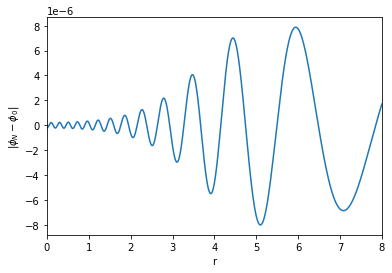

In [ ]:
plt.plot(rplot, erro)
plt.xlabel('r')
plt.xlim(0,8)
plt.ylabel("$|\phi_N - \phi_0|$")
plt.show()

In [18]:
Pi_0 = np.zeros(N+1)
b0 = np.dot(Pi_0, psi)
Pi = np.dot(b0, psi)

c0 = np.zeros([N+1])     # guess value
for i in range(N+1):
  c0[i]  =   0.001
  
Chi=np.dot(c0,psi)    
rChi=np.dot(c0,rpsi)
rrChi=np.dot(c0,rrpsi)     

H0 = 4*rChi**2 + 4*rrChi + 8/r*rChi + 1/2*(rPhi)**2

JH = 8*np.dot(c0,rpsi)*rpsi + 4*rrpsi + 8/r*rpsi     # Jacobian Matrix

inv_JH = np.linalg.inv(JH)

N_int = 50

tolerance = 1e-40    # tolerance

N_int = 10

#tol = 1e-29     # tolerance
#while min(abs(np.dot(H0, inv_JH))) >= tol:

# Newton Raphson loop
for i in range(N_int):
  Chi=np.dot(c0,psi)
  rChi=np.dot(c0,rpsi)
  rrChi=np.dot(c0,rrpsi)
  H0 = 4*rChi**2 + 4*rrChi + 8/r*rChi + 1/2*(rPhi)**2
  JH = 8*np.dot(c0,rpsi)*rpsi + 4*rrpsi + 8/r*rpsi
  cnew = c0 - np.dot(H0, inv_JH)
  if min(abs(cnew-c0)) < tolerance:
    break
  print(min(abs(cnew-c0)), end=' ')
  c0 = cnew

out_c0 = open('c0_30_L02.txt', 'a')
out_c0.write(' ' +' '.join(str('%.18f'%n) for n in c0)+'\n')
out_c0.close()

c0
     

0.0006863985854582655 1.1659583880805955e-07 3.8442484183265613e-10 3.8046162102802537e-10 2.4289494144850395e-11 1.0572378052107685e-12 3.6357114568047667e-14 1.0564002747555726e-15 2.6890649097363866e-17 6.108695736479607e-19 

array([ 7.73541561e-02,  1.06698785e-02, -1.15379230e-03, -1.69933449e-03,
       -6.18886925e-04, -4.68589278e-05,  3.19965049e-04,  3.57879643e-04,
        2.72165702e-05, -2.25116068e-04, -1.43744755e-04,  5.59027427e-05,
        1.13501460e-04,  3.30071151e-05, -4.17775047e-05, -4.13235243e-05,
       -2.79407090e-06,  1.95725036e-05,  1.37879049e-05, -8.35089296e-07,
       -7.31905669e-06, -4.39983581e-06,  6.48067127e-07,  2.67826504e-06,
        1.60682141e-06, -1.29933442e-07, -9.02101904e-07, -5.86315237e-07,
        3.41239398e-08,  3.91125243e-07,  3.00478061e-07])

Field equations

In [19]:
# Equation for Krr: momentum constraint

# Initial values of Krr: Base functions of Krr

SB1 = 1/2*(SB[1:(N+2),:] + SB[0:(N+1),:])          # VERIFICADO
rSB1 = 1/2*(rSB[1:(N+2),:] + rSB[0:(N+1),:])
rrSB1 = 1/2*(rrSB[1:(N+2),:] + rrSB[0:(N+1),:])


# Base functions for Beta

SB2 = np.zeros([N+1,N+1])      
rSB2 = np.zeros([N+1,N+1])
rrSB2 = np.zeros([N+1,N+1])

for i in range(N+1):                                                   # VERIFICADO
  SB2[i,] = np.sin((2*(i+1/2)+1)*np.arctan(L0/r))                                                  

for i in range(N+1):
  rSB2[i,] = -np.cos((2*i+2)*np.arctan(L0/r))*(2*i+2)*L0/(r**2*(1+L0**2/r**2))

for i in range(N+1):
  rrSB2[i,] = -np.sin((2*i+2)*np.arctan(L0/r))*(2*i+2)**2*L0**2/(r**4*(1+L0**2/r**2)**2)+2*np.cos((2*i+2)*np.arctan(L0/r))*(2*i+2)*L0/(r**3*(1+L0**2/r**2))-2*np.cos((2*i+2)*np.arctan(L0/r))*(2*i+2)*L0**3/(r**5*(1+L0**2/r**2)**2)


    

Quadrature Integration

In [20]:
Nq = int(3/2*N)           # Quadrature truncation

gauss_quadrature = np.polynomial.legendre.leggauss(Nq + 1) 

new_col = gauss_quadrature[0]            # Legendre quadrature points


# Legendre Polinomials

P = np.zeros([Nq+3,Nq+1])
colP = np.zeros([Nq+3,Nq+1])

P[0,] = 1
P[1,] = new_col

colP[0,] = 0
colP[1,] = 1

for i in range(2,Nq+3):
  P[i,] = ((2*i-1)*new_col*P[i-1,] - (i-1)*P[i-2,])/(i)   

for i in range(2,Nq+3):
  colP[i,] = i*P[i-1] + new_col*colP[i-1]

P_max = P[Nq+1]

colP_max = colP[Nq+1]

wq_col = 2/((1-new_col**2)*colP_max**2)    # Legendre weight (Verificado)

rq = L0*(1+new_col)/(1-new_col)            # Physical quadrature domain

qSB = np.zeros([Nq+3,Nq+1])                # Base function in quadrature points
qrSB = np.zeros([Nq+3,Nq+1])
qrrSB = np.zeros([Nq+3,Nq+1])




for i in range(Nq+1+1+1):
  qSB[i,] = np.sin((2*i+1)*np.arctan(L0/rq))                                                  

for i in range(Nq+1+1+1):
  qrSB[i,] = -np.cos((2*i+1)*np.arctan(L0/rq))*(2*i+1)*L0/(rq**2*(1+L0**2/rq**2))

for i in range(Nq+1+1+1):
  qrrSB[i,] = -np.sin((2*i+1)*np.arctan(L0/rq))*(2*i+1)**2*L0**2/(rq**4*(1+L0**2/rq**2)**2)+2*np.cos((2*i+1)*np.arctan(L0/rq))*(2*i+1)*L0/(rq**3*(1+L0**2/rq**2))-2*np.cos((2*i+1)*np.arctan(L0/rq))*(2*i+1)*L0**3/(rq**5*(1+L0**2/rq**2)**2)                                         


qpsi = qSB[0:N+1,:]
rqpsi = qrSB[0:N+1,:]
rrqpsi = qrrSB[0:N+1,:]

# Initial values of Krr:


qSB1 = 1/2*(qSB[1:(N+2),:] + qSB[0:(N+1),:])          # VERIFICADO
qrSB1 = 1/2*(qrSB[1:(N+2),:] + qrSB[0:(N+1),:])
qrrSB1 = 1/2*(qrrSB[1:(N+2),:] + qrrSB[0:(N+1),:])


#qKrr = np.dot(ck0, qSB1) 

# Alpha na origem

psi_0 = np.zeros(N+1)

for i in range(N+1):
  psi_0[i,] = np.sin((2*i+1)*math.pi/2)     # arccot(0) = Pi/2  

#Alpha_0 = 1 + np.dot(al0, psi_0) 



In [21]:
# Runge Kutta Fehlberg : adaptative step

tf = 7

h_max = 0.001
h_min = 0.00001
tol = 1e-9        # Tolerance
h = h_min

It = int(tf/h)

t = 0

#phi_set = np.zeros([It,M])   
#chi_set = np.zeros([It,M])
#pi_set = np.zeros([It,M])
#L2HC = np.zeros([It])  
#Alpha_origin = np.zeros([It])
#phi_origin = np.zeros([It]) 

V = 0

#print 'Time step:', h
#print 'Steps:', It

for i in range(It): 

  # First step
  Phi = np.dot(a0, psi)      
  rPhi = np.dot(a0, rpsi)
  rrPhi = np.dot(a0, rrpsi)      
  Pi = np.dot(b0, psi) 
  rPi= np.dot(b0, rpsi)
  Chi = np.dot(c0, psi) 
  rChi = np.dot(c0, rpsi)
  rrChi = np.dot(c0, rrpsi)   
  Matrix_Krr = 2*rChi*SB1 + rSB1 + 3/r*SB1 
  inv_matrix_krr = np.linalg.inv(Matrix_Krr)
  rhsk = - Pi*rPhi*np.exp(4*Chi)
  ck0 = np.dot(rhsk, inv_matrix_krr)
  Krr = np.dot(ck0, SB1) 
  rKrr = np.dot(ck0, rSB1)
  Matrix_Alpha = rrpsi + 2*(1/r + rChi)*rpsi - 3/2*np.exp(-4*Chi)*Krr**2*psi - np.exp(4*Chi)*(Pi**2 - V)*psi 
  inv_matrix_alpha = np.linalg.inv(Matrix_Alpha)
  rhsal = 3/2*np.exp(-4*Chi)*Krr**2 + np.exp(4*Chi)*(Pi**2-V)
  al0 = np.dot(rhsal, inv_matrix_alpha)
  Alpha = 1 + np.dot(al0, psi)
  rAlpha = np.dot(al0, rpsi)
  rrAlpha = np.dot(al0, rrpsi)
  Matrix_Beta = rSB2/r - SB2/r**2
  inv_matrix_beta = np.linalg.inv(Matrix_Beta)
  rhsbe = 3/2*Alpha*np.exp(-4*Chi)*Krr/r
  be0 = np.dot(rhsbe , inv_matrix_beta)
  Beta = np.dot(be0, SB2)
  rBeta = np.dot(be0, rSB2)
  db = np.dot(Beta*rPi + np.exp(-4*Chi)*(2*Alpha/r + rAlpha + 2*rChi*Alpha)*rPhi + np.exp(-4*Chi)*Alpha*rrPhi - Alpha* V, inv_psi)
  dc = np.dot(Beta*rChi + Beta/2/r + Alpha/4*np.exp(-4*Chi)*Krr, inv_psi)   
  da = np.dot(Alpha*Pi + Beta*rPhi, inv_psi)   
  K1 = h*(dc)
  L1 = h*(da)
  N1 = h*(db)
  
  # L2-error associated to the Hamiltonian constraint
  qPhi = np.dot(a0, qpsi)      
  rqPhi= np.dot(a0, rqpsi)
  qPi = np.dot(b0, qpsi) 
  qChi = np.dot(c0, qpsi)
  rqChi = np.dot(c0, rqpsi)
  rrqChi = np.dot(c0, rrqpsi) 
  qKrr = np.dot(ck0, qSB1)
  H = 4*rqChi**2 + 4*rrqChi + 8*rqChi/rq + 3/4*np.exp(-4*qChi)*qKrr**2 + np.exp(4*qChi)*(1/2*qPi**2 + np.exp(-4*qChi)/2*rqPhi**2)   # Hamiltonian constraint (HC)
#  L2HC[i,] = (1/2*np.dot(H**2,wq_col))**(1/2)     # L2 error of HC 
  
  # Alpha in r=0
#  Alpha_origin[i] = 1 + np.dot(al0, psi_0)

  #Phi origin:
#  phi_origin[i] = np.dot(a0, psi_0)

  # Second step
  Phi = np.dot(a0 + L1/4, psi)     
  rPhi= np.dot(a0 + L1/4 , rpsi)
  rrPhi = np.dot(a0 + L1/4, rrpsi) 
  Pi = np.dot(b0 + N1/4, psi)
  rPi= np.dot(b0 + N1/4, rpsi)
  Chi = np.dot(c0 + K1/4, psi)
  rChi = np.dot(c0 + K1/4, rpsi)
  rrChi = np.dot(c0 + K1/4, rrpsi)
  Matrix_Krr = 2*rChi*SB1 + rSB1 + 3/r*SB1 
  inv_matrix_krr = np.linalg.inv(Matrix_Krr)
  rhsk = - Pi*rPhi*np.exp(4*Chi)
  ck0 = np.dot(rhsk, inv_matrix_krr)
  Krr = np.dot(ck0, SB1) 
  rKrr = np.dot(ck0, rSB1)
  Matrix_Alpha = rrpsi + 2*(1/r + rChi)*rpsi - 3/2*np.exp(-4*Chi)*Krr**2*psi - np.exp(4*Chi)*(Pi**2 - V)*psi 
  inv_matrix_alpha = np.linalg.inv(Matrix_Alpha)
  rhsal = 3/2*np.exp(-4*Chi)*Krr**2 + np.exp(4*Chi)*(Pi**2-V)
  al0 = np.dot(rhsal, inv_matrix_alpha)
  Alpha = 1 + np.dot(al0, psi)
  rAlpha = np.dot(al0, rpsi)
  rrAlpha = np.dot(al0, rrpsi)
  Matrix_Beta = rSB2/r - SB2/r**2
  inv_matrix_beta = np.linalg.inv(Matrix_Beta)
  rhsbe = 3/2*Alpha*np.exp(-4*Chi)*Krr/r
  be0 = np.dot(rhsbe , inv_matrix_beta)
  Beta = np.dot(be0, SB2)
  rBeta = np.dot(be0, rSB2)
  db = np.dot(Beta*rPi + np.exp(-4*Chi)*(2*Alpha/r + rAlpha + 2*rChi*Alpha)*rPhi + np.exp(-4*Chi)*Alpha*rrPhi - Alpha* V, inv_psi)   
  dc = np.dot(Beta*rChi + Beta/2/r + Alpha/4*np.exp(-4*Chi)*Krr, inv_psi)    
  da = np.dot(Alpha*Pi + Beta*rPhi, inv_psi)   
  K2 = h*(dc)
  L2 = h*(da)
  N2 = h*(db)

  # Third step
  Phi = np.dot(a0 + 3/(32)*L1 + 9/(32)*L2, psi)     
  rPhi = np.dot(a0 + 3/(32)*L1 + 9/(32)*L2 , rpsi)
  rrPhi = np.dot(a0 + 3/(32)*L1 + 9/(32)*L2, rrpsi) 
  Pi = np.dot(b0 + 3/(32)*N1 + 9/(32)*N2, psi)
  rPi= np.dot(b0 + 3/(32)*N1 + 9/(32)*N2, rpsi)
  Chi = np.dot(c0 + 3/(32)*K1 + 9/(32)*K2, psi)
  rChi = np.dot(c0 + 3/(32)*K1 + 9/(32)*K2, rpsi)
  rrChi = np.dot(c0 +3/(32)*K1 + 9/(32)*K2, rrpsi)
  Matrix_Krr = 2*rChi*SB1 + rSB1 + 3/r*SB1
  inv_matrix_krr = np.linalg.inv(Matrix_Krr)
  rhsk = - Pi*rPhi*np.exp(4*Chi)
  ck0 = np.dot(rhsk, inv_matrix_krr)
  Krr = np.dot(ck0, SB1) 
  rKrr = np.dot(ck0, rSB1)
  Matrix_Alpha = rrpsi + 2*(1/r + rChi)*rpsi - 3/2*np.exp(-4*Chi)*Krr**2*psi - np.exp(4*Chi)*(Pi**2 - V)*psi 
  inv_matrix_alpha = np.linalg.inv(Matrix_Alpha)
  rhsal = 3/2*np.exp(-4*Chi)*Krr**2 + np.exp(4*Chi)*(Pi**2-V)
  al0 = np.dot(rhsal, inv_matrix_alpha)
  Alpha = 1 + np.dot(al0, psi)
  rAlpha = np.dot(al0, rpsi)
  rrAlpha = np.dot(al0, rrpsi)
  Matrix_Beta = rSB2/r - SB2/r**2
  inv_matrix_beta = np.linalg.inv(Matrix_Beta)
  rhsbe = 3/2*Alpha*np.exp(-4*Chi)*Krr/r
  be0 = np.dot(rhsbe , inv_matrix_beta)
  Beta = np.dot(be0, SB2)
  rBeta = np.dot(be0, rSB2)
  db = np.dot(Beta*rPi + np.exp(-4*Chi)*(2*Alpha/r + rAlpha + 2*rChi*Alpha)*rPhi + np.exp(-4*Chi)*Alpha*rrPhi - Alpha* V, inv_psi)   
  dc = np.dot(Beta*rChi + Beta/2/r + Alpha/4*np.exp(-4*Chi)*Krr, inv_psi)    
  da = np.dot(Alpha*Pi + Beta*rPhi, inv_psi)   
  K3 = h*(dc)
  L3 = h*(da)
  N3 = h*(db) 

  # Forth step
  Phi = np.dot(a0 + (1932)/(2197)*L3 - (7200)/(2197)*L2 + (7296)/(2197)*L3, psi)     
  rPhi= np.dot(a0 + (1932)/(2197)*L3 - (7200)/(2197)*L2 + (7296)/(2197)*L3 , rpsi)
  rrPhi = np.dot(a0 + (1932)/(2197)*L3 - (7200)/(2197)*L2 + (7296)/(2197)*L3, rrpsi) 
  Pi = np.dot(b0 + (1932)/(2197)*N3 - (7200)/(2197)*N2 + (7296)/(2197)*N3, psi)
  rPi= np.dot(b0 + (1932)/(2197)*N3 - (7200)/(2197)*N2 + (7296)/(2197)*N3, rpsi)
  Chi = np.dot(c0 + (1932)/(2197)*K3 - (7200)/(2197)*K2 + (7296)/(2197)*K3, psi)
  rChi = np.dot(c0 + (1932)/(2197)*K3 - (7200)/(2197)*K2 + (7296)/(2197)*K3, rpsi)
  rrChi = np.dot(c0 + (1932)/(2197)*K3 - (7200)/(2197)*K2 + (7296)/(2197)*K3, rrpsi)
  Matrix_Krr = 2*rChi*SB1 + rSB1 + 3/r*SB1 
  inv_matrix_krr = np.linalg.inv(Matrix_Krr)
  rhsk = - Pi*rPhi*np.exp(4*Chi)
  ck0 = np.dot(rhsk, inv_matrix_krr)
  Krr = np.dot(ck0, SB1) 
  rKrr = np.dot(ck0, rSB1)
  Matrix_Alpha = rrpsi + 2*(1/r + rChi)*rpsi - 3/2*np.exp(-4*Chi)*Krr**2*psi - np.exp(4*Chi)*(Pi**2 - V)*psi 
  inv_matrix_alpha = np.linalg.inv(Matrix_Alpha)
  rhsal = 3/2*np.exp(-4*Chi)*Krr**2 + np.exp(4*Chi)*(Pi**2-V)
  al0 = np.dot(rhsal, inv_matrix_alpha)
  Alpha = 1 + np.dot(al0, psi)
  rAlpha = np.dot(al0, rpsi)
  rrAlpha = np.dot(al0, rrpsi)
  Matrix_Beta = rSB2/r - SB2/r**2
  inv_matrix_beta = np.linalg.inv(Matrix_Beta)
  rhsbe = 3/2*Alpha*np.exp(-4*Chi)*Krr/r
  be0 = np.dot(rhsbe , inv_matrix_beta)
  Beta = np.dot(be0, SB2)
  rBeta = np.dot(be0, rSB2)
  db = np.dot(Beta*rPi + np.exp(-4*Chi)*(2*Alpha/r + rAlpha + 2*rChi*Alpha)*rPhi + np.exp(-4*Chi)*Alpha*rrPhi - Alpha* V, inv_psi)   
  dc = np.dot(Beta*rChi + Beta/2/r + Alpha/4*np.exp(-4*Chi)*Krr, inv_psi)    
  da = np.dot(Alpha*Pi + Beta*rPhi, inv_psi)   
  K4 = h*(dc)
  L4 = h*(da)
  N4 = h*(db)  
  
  # Fifth step
  Phi = np.dot(a0 + (439)/(216)*L1 - 8*L2 + (3680)/(513)*L3 - (845)/(4104)*L4, psi)     
  rPhi= np.dot(a0 + (439)/(216)*L1 - 8*L2 + (3680)/(513)*L3 - (845)/(4104)*L4 , rpsi)
  rrPhi = np.dot(a0 + (439)/(216)*L1 - 8*L2 + (3680)/(513)*L3 - (845)/(4104)*L4, rrpsi) 
  Pi = np.dot(b0 + (439)/(216)*N1 - 8*N2 + (3680)/(513)*N3 - (845)/(4104)*N4, psi)
  rPi= np.dot(b0 + (439)/(216)*N1 - 8*N2 + (3680)/(513)*N3 - (845)/(4104)*N4, rpsi)
  Chi = np.dot(c0 + (439)/(216)*K1 - 8*K2 + (3680)/(513)*K3 - (845)/(4104)*K4, psi)
  rChi = np.dot(c0 + (439)/(216)*K1 - 8*K2 + (3680)/(513)*K3 - (845)/(4104)*K4, rpsi)
  rrChi = np.dot(c0 + (439)/(216)*K1 - 8*K2 + (3680)/(513)*K3 - (845)/(4104)*K4, rrpsi)
  Matrix_Krr = 2*rChi*SB1 + rSB1 + 3/r*SB1 
  inv_matrix_krr = np.linalg.inv(Matrix_Krr)
  rhsk = - Pi*rPhi*np.exp(4*Chi)
  ck0 = np.dot(rhsk, inv_matrix_krr)
  Krr = np.dot(ck0, SB1) 
  rKrr = np.dot(ck0, rSB1)
  Matrix_Alpha = rrpsi + 2*(1/r + rChi)*rpsi - 3/2*np.exp(-4*Chi)*Krr**2*psi - np.exp(4*Chi)*(Pi**2 - V)*psi 
  inv_matrix_alpha = np.linalg.inv(Matrix_Alpha)
  rhsal = 3/2*np.exp(-4*Chi)*Krr**2 + np.exp(4*Chi)*(Pi**2-V)
  al0 = np.dot(rhsal, inv_matrix_alpha)
  Alpha = 1 + np.dot(al0, psi)
  rAlpha = np.dot(al0, rpsi)
  rrAlpha = np.dot(al0, rrpsi)
  Matrix_Beta = rSB2/r - SB2/r**2
  inv_matrix_beta = np.linalg.inv(Matrix_Beta)
  rhsbe = 3/2*Alpha*np.exp(-4*Chi)*Krr/r
  be0 = np.dot(rhsbe , inv_matrix_beta)
  Beta = np.dot(be0, SB2)
  rBeta = np.dot(be0, rSB2)
  db = np.dot(Beta*rPi + np.exp(-4*Chi)*(2*Alpha/r + rAlpha + 2*rChi*Alpha)*rPhi + np.exp(-4*Chi)*Alpha*rrPhi - Alpha* V, inv_psi)   
  dc = np.dot(Beta*rChi + Beta/2/r + Alpha/4*np.exp(-4*Chi)*Krr, inv_psi)    
  da = np.dot(Alpha*Pi + Beta*rPhi, inv_psi)   
  K5 = h*(dc)
  L5 = h*(da)
  N5 = h*(db)  
  
  # Sixth step
  Phi = np.dot(a0 - (8)/(27)*L1 - 2*L2 - (3544)/(2565)*L3 + (1859)/(4104)*L4 - (11)/(40)*L5, psi)     
  rPhi= np.dot(a0 + (8)/(27)*L1 - 2*L2 - (3544)/(2565)*L3 + (1859)/(4104)*L4 - (11)/(40)*L5 , rpsi)
  rrPhi = np.dot(a0 + (8)/(27)*L1 - 2*L2 - (3544)/(2565)*L3 + (1859)/(4104)*L4 - (11)/(40)*L5, rrpsi) 
  Pi = np.dot(b0 + (8)/(27)*N1 - 2*N2 - (3544)/(2565)*N3 + (1859)/(4104)*N4 - (11)/(40)*N5, psi)
  rPi= np.dot(b0 + (8)/(27)*N1 - 2*N2 - (3544)/(2565)*N3 + (1859)/(4104)*N4 - (11)/(40)*N5, rpsi)
  Chi = np.dot(c0 + (8)/(27)*K1 - 2*K2 - (3544)/(2565)*K3 + (1859)/(4104)*K4 - (11)/(40)*K5, psi)
  rChi = np.dot(c0 + (8)/(27)*K1 - 2*K2 - (3544)/(2565)*K3 + (1859)/(4104)*K4 - (11)/(40)*K5, rpsi)
  rrChi = np.dot(c0 + (8)/(27)*K1 - 2*K2 - (3544)/(2565)*K3 + (1859)/(4104)*K4 - (11)/(40)*K5, rrpsi)
  Matrix_Krr = 2*rChi*SB1 + rSB1 + 3/r*SB1 
  inv_matrix_krr = np.linalg.inv(Matrix_Krr)
  rhsk = - Pi*rPhi*np.exp(4*Chi)
  ck0 = np.dot(rhsk, inv_matrix_krr)
  Krr = np.dot(ck0, SB1) 
  rKrr = np.dot(ck0, rSB1)
  Matrix_Alpha = rrpsi + 2*(1/r + rChi)*rpsi - 3/2*np.exp(-4*Chi)*Krr**2*psi - np.exp(4*Chi)*(Pi**2 - V)*psi 
  inv_matrix_alpha = np.linalg.inv(Matrix_Alpha)
  rhsal = 3/2*np.exp(-4*Chi)*Krr**2 + np.exp(4*Chi)*(Pi**2-V)
  al0 = np.dot(rhsal, inv_matrix_alpha)
  Alpha = 1 + np.dot(al0, psi)
  rAlpha = np.dot(al0, rpsi)
  rrAlpha = np.dot(al0, rrpsi)
  Matrix_Beta = rSB2/r - SB2/r**2
  inv_matrix_beta = np.linalg.inv(Matrix_Beta)
  rhsbe = 3/2*Alpha*np.exp(-4*Chi)*Krr/r
  be0 = np.dot(rhsbe , inv_matrix_beta)
  Beta = np.dot(be0, SB2)
  rBeta = np.dot(be0, rSB2)
  db = np.dot(Beta*rPi + np.exp(-4*Chi)*(2*Alpha/r + rAlpha + 2*rChi*Alpha)*rPhi + np.exp(-4*Chi)*Alpha*rrPhi - Alpha* V, inv_psi)   
  dc = np.dot(Beta*rChi + Beta/2/r + Alpha/4*np.exp(-4*Chi)*Krr, inv_psi)    
  da = np.dot(Alpha*Pi + Beta*rPhi, inv_psi)   
  K6 = h*(dc)
  L6 = h*(da)
  N6 = h*(db) 

  print(i)

  Error_R_1 = []
  for n in range(len(a0)):
    Error_R_1.append(1/360*L1[n]-128/4275*L3[n]-2197/75240*L4[n]+1/50*L5[n]+2/55*L6[n])
  Error_R = max(Error_R_1)

  print('Error = ',Error_R)
  print('h = ', h)

  if Error_R <= tol or h == h_min:
      a = []
      b = []
      c = []
      for j in range(len(a0)):
        a.append(a0[j] + (16)/(135)*L1[j] + (6656)/(12825)*L3[j] + (28561)/(56430)*L4[j] - 9/(50)*L5[j] + 2/(55)*L6[j])
      for j in range(len(a0)):
        b.append(b0[j] + (16)/(135)*N1[j] + (6656)/(12825)*N3[j] + (28561)/(56430)*N4[j] - 9/(50)*N5[j] + 2/(55)*N6[j])
      for j in range(len(a0)):
        c.append(c0[j] + (16)/(135)*K1[j] + (6656)/(12825)*K3[j] + (28561)/(56430)*K4[j] - 9/(50)*K5[j] + 2/(55)*K6[j])
      t4 = str(t)
      t = t + h
      a0 = a
      b0 = b
      c0 = c
      t3=str(t)
      print(a0)
      out_a = open('a_30_L02.txt', 'a')
      out_a.write(t3 +' ' +' '.join(str('%.18f'%n) for n in a0)+'\n')
      out_b = open('b_30_L02.txt', 'a')
      out_b.write(t3 +' ' +' '.join(str('%.18f'%n) for n in b0)+'\n')
      out_c = open('c_30_L02.txt', 'a')
      out_c.write(t4 +' ' +' '.join(str('%.18f'%n) for n in c0)+'\n')
 #     out_H.write(t4 +' ' +' '.join(str('%.18f'%n) for n in H)+'\n')
      h = h_max
  else:
    h = h*0.01*(tol/(Error_R))**(1/4)
    if h >= h_max:
      h = h_max
    if h < h_min:
      h = h_min



  # Evolution functions  
  # phi_set[i,:] = np.dot(a, psiplot)
  # pi_set[i,:] = np.dot(b, psiplot)
  # chi_set[i,:] = np.dot(c, psiplot)
  
  

Streaming output truncated to the last 5000 lines.
h =  1e-05
[0.11899138086290105, 0.12328248978888866, -0.07246839756166673, -0.09441080734604314, 0.016366459698573223, 0.054544837751353915, 0.014069730076188265, -0.019345904456973106, -0.016579338257192093, -0.00044255959671382394, 0.007326652988373551, 0.004895260802602583, -5.273293266223803e-05, -0.002274692561219386, -0.0016345125351088523, -0.00018837096323119198, 0.000607322820549061, 0.0005739462473033947, 0.00018857287085029267, -0.0001112198398369575, -0.00018532006784794866, -0.00010952287526099947, -8.495275438781874e-06, 4.532952834539509e-05, 4.568384906793506e-05, 2.0407140701588462e-05, -2.7900951081785992e-06, -1.2200443502670874e-05, -1.038073663889758e-05, -5.104490630771689e-06, -1.563525618466721e-06]
30849
Error =  2.3443431614362693e-08
h =  0.001
30850
Error =  2.341760595792756e-12
h =  1e-05
[0.11899163430122488, 0.12328233907986012, -0.07246861405148884, -0.09441041169107793, 0.0163665178353969, 0.054544501

KeyboardInterrupt: ignored

Text(0.5, 1.0, 'log(L2Hc) para $N = 30$, $L_0 = 6$ e $A_0 = 0.05$')

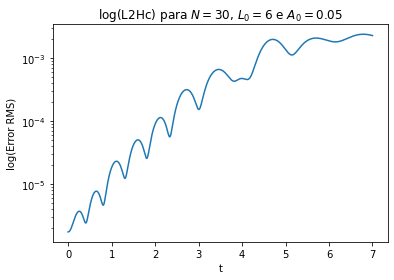

In [ ]:
# Erro L2 of Hamiltonian constraint

plt.plot(t,L2HC)
plt.yscale("log")
plt.ylabel("log(Error RMS)")
plt.xlabel("t")
plt.title("log(L2Hc) para $N = 30$, $L_0 = 6$ e $A_0 = 0.05$")

In [ ]:
L2HC_30max_L06 = max(L2HC)


L2HC_30max_L06

0.002484056936002491

In [ ]:
L2HC_60max_L06 = max(L2HC)

L2HC_60max_L06

4.2354407714815734e-05

In [ ]:
L2HC_90max_L06 = max(L2HC)

L2HC_90max_L06

8.707534373859146e-07

In [ ]:
L2HC_120max_L06 = max(L2HC)

L2HC_120max_L06

1.1946556397992398e-08

In [ ]:
L2HC_150max_L06 = max(L2HC)

L2HC_150max_L06 

3.0319088210686514e-09

In [ ]:
L2HC_180max_L06 = max(L2HC)

L2HC_180max_L06

1.8609523773245208e-09

In [ ]:
L2HC_210max_L06 = max(L2HC)

L2HC_210max_L06

1.2751386846020075e-09

In [ ]:
L2HC_30max_L02

0.08368416315314683

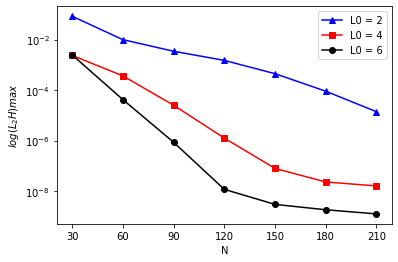

In [ ]:


L2HC_L02 = [L2HC_30max_L02, L2HC_60max_L02,L2HC_90max_L02, L2HC_120max_L02,L2HC_150max_L02, L2HC_180max_L02,L2HC_210max_L02]



L2HC_L04 = [L2HC_30max_L04, L2HC_60max_L04,L2HC_90max_L04, L2HC_120max_L04,L2HC_150max_L04, L2HC_180max_L04,L2HC_210max_L04]



L2HC_L06 = [L2HC_30max_L06, L2HC_60max_L06,L2HC_90max_L06, L2HC_120max_L06,L2HC_150max_L06, L2HC_180max_L06,L2HC_210max_L06]

N = [30,60,90,120,150,180,210]

N_max = 210

plt.plot(N, L2HC_L02, '-b^', label = "L0 = 2")
plt.plot(N, L2HC_L04, '-rs',label = "L0 = 4")
plt.plot(N, L2HC_L06, '-ko',label = "L0 = 6")
plt.xticks(N)
plt.xlabel('N')
plt.ylabel('$log(L_2 H)max$')
plt.yscale('log')
plt.legend()
plt.show()